# Préparez des données pour un organisme de santé publique

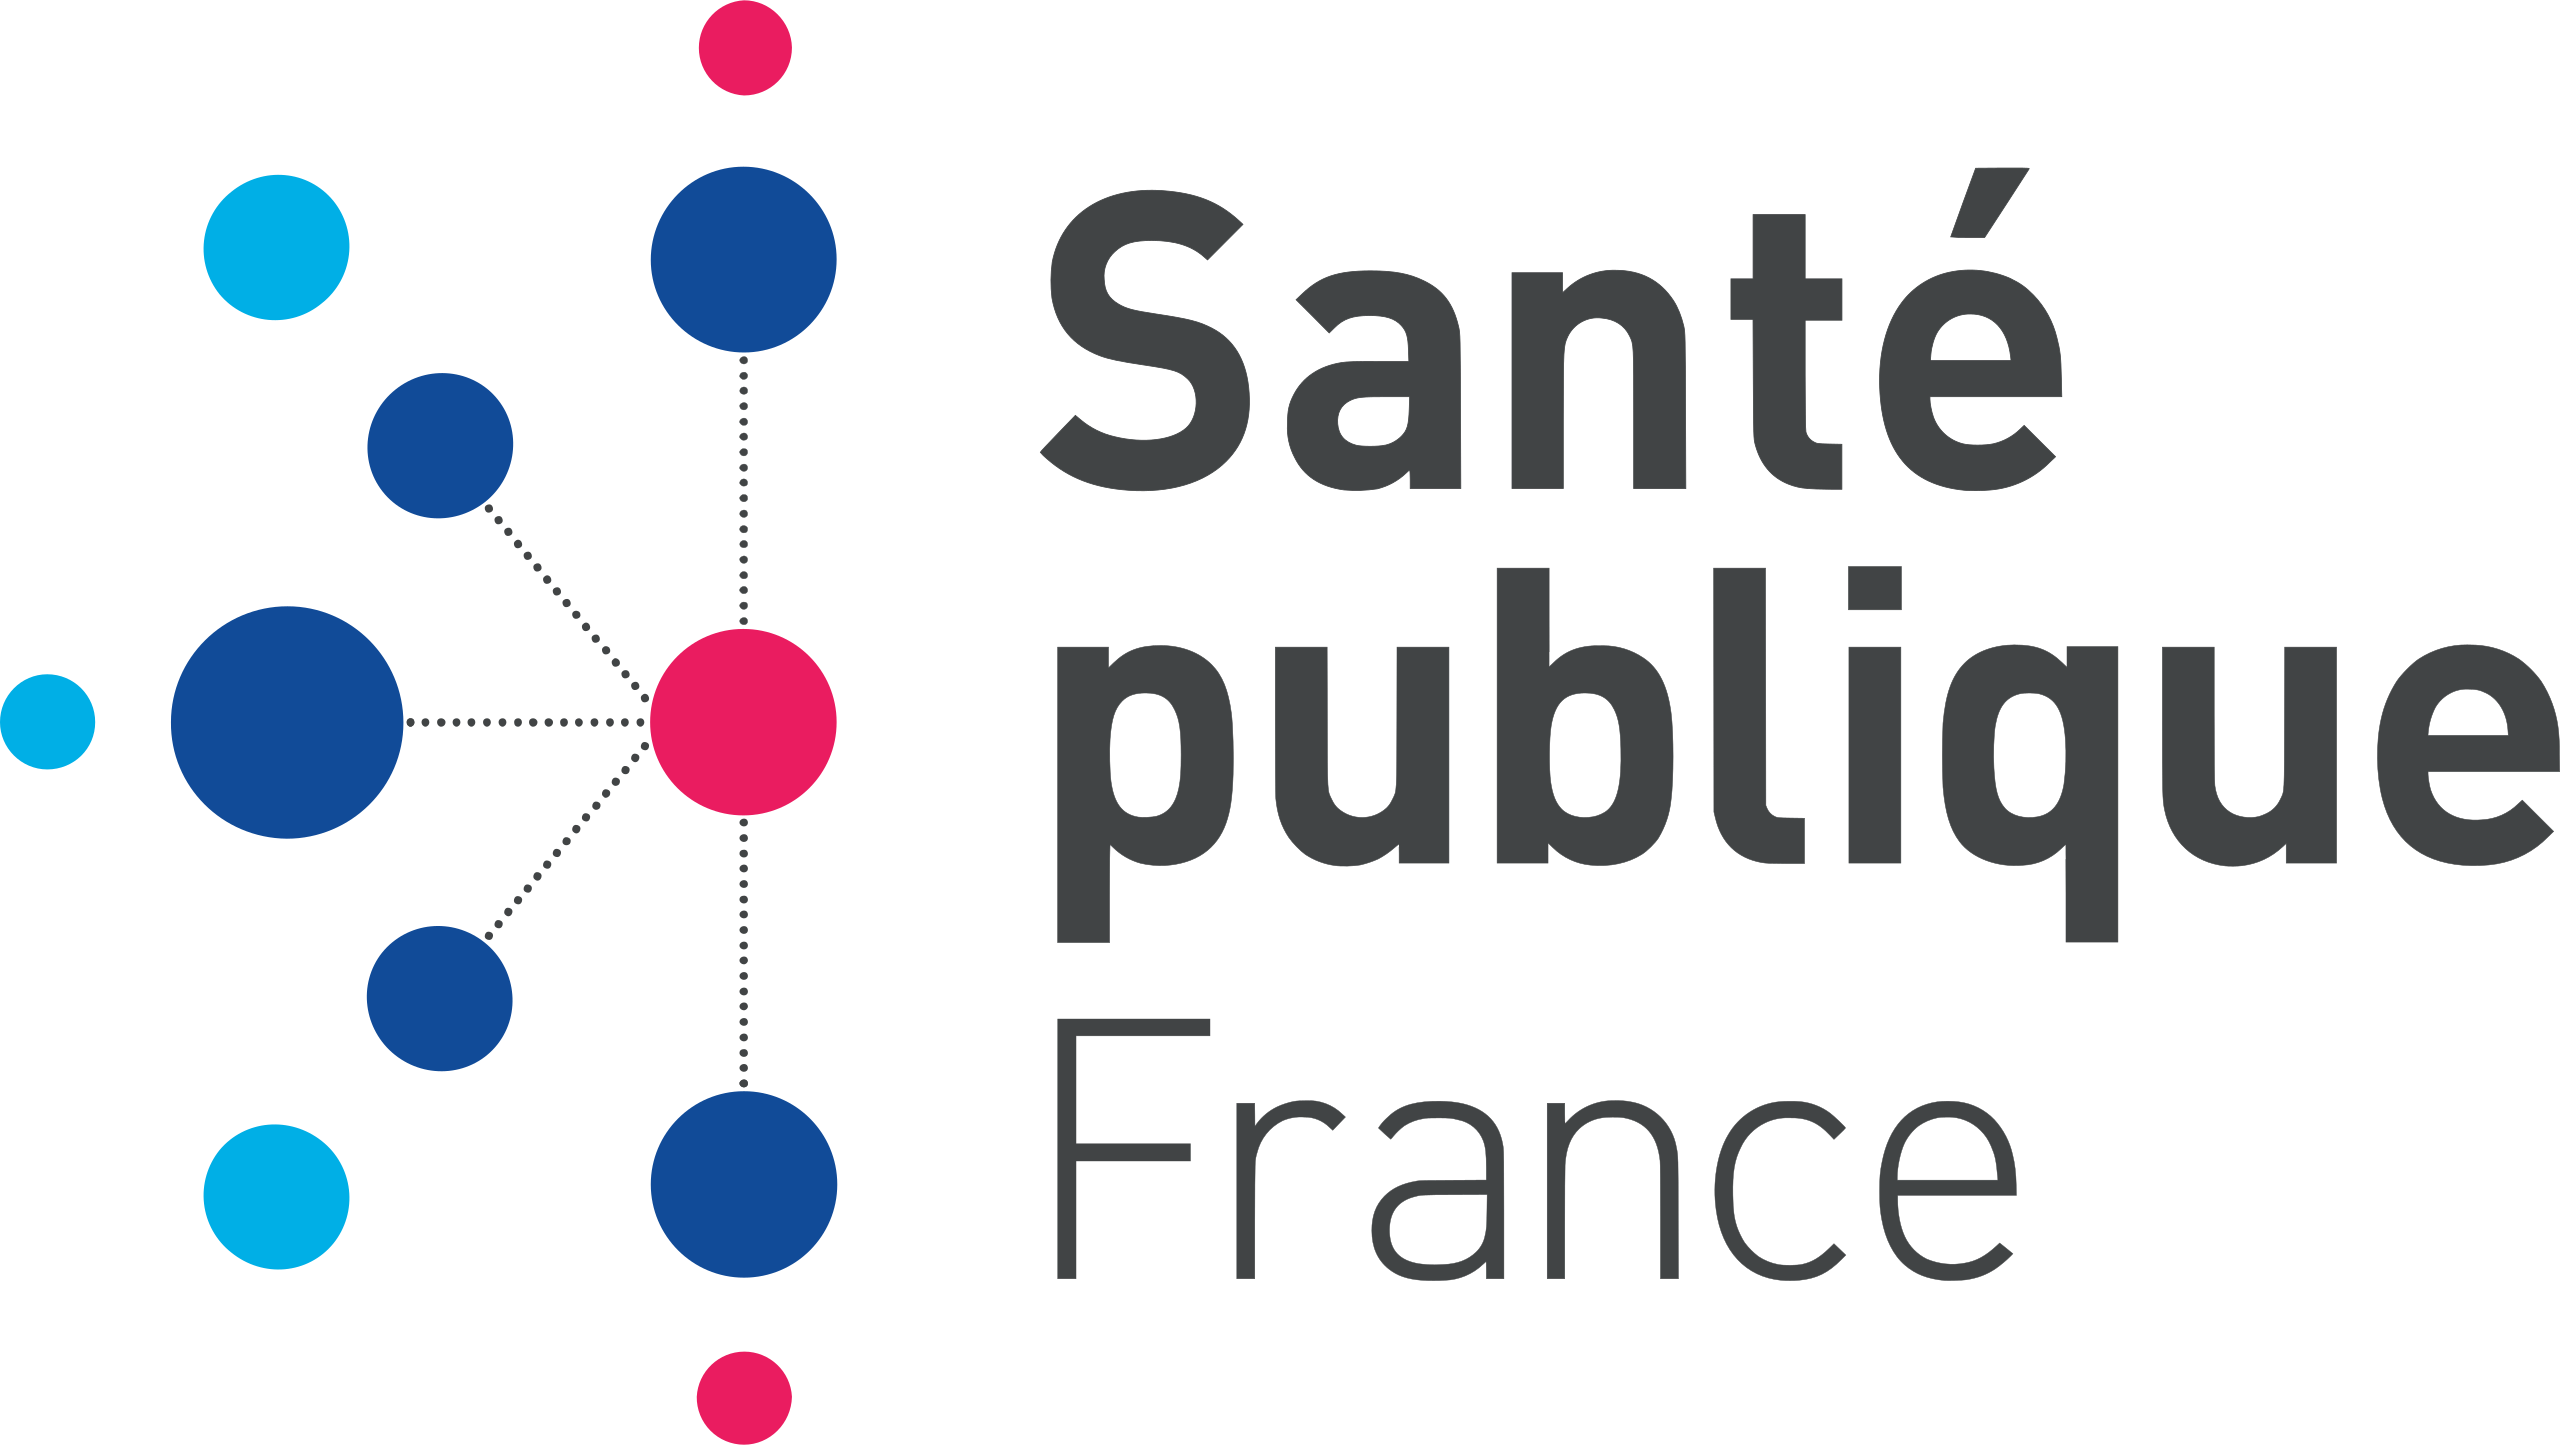



## 1. Introduction

L'agence Santé publique France souhaite améliorer sa base de données Open Food Facts qui permet de connaître la qualité nutritionnelle de leur produits.  
Ils souhaitent développer un système de suggestion ou d'auto-complétion pour remplir la base de données plus efficacement.

Mon rôle est de déterminer la faisabilité de cette application en analysant ces données et en produisants des graphiques compréhensible à tous.

**Données d'entrée**:
- [Tous les produits](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-scientist/P2/fr.openfoodfacts.org.products.csv.zip)
- [Description de toutes les colonnes](https://world.openfoodfacts.org/data/data-fields.txt)

**Données de sortie**: 
- Rapport d'éxploration
- Conclusion sur la faisabilité de l'application.

<!---
Critères d'évaluation:
- Vous avez défini les objectifs de son nettoyage de données en fonction de la problématique métier
- Vous avez défini sa démarche de préparation et nettoyage des données
-->

---

Je remarque que le fichier ne contient aucune données qui entrerait en conflit avec les 5 principes du RGPD (Règlement Général sur la Protection des Données):
- **Le principe de finalité** : le responsable d'un fichier ne peut enregistrer et utiliser des informations sur des personnes physiques que dans un but bien précis, légal et légitime ;
- **Le principe de proportionnalité et de pertinence** : les informations enregistrées doivent être pertinentes et strictement nécessaires au regard de la finalité du fichier ;
- **Le principe d'une durée de conservation limitée** : il n'est pas possible de conserver des informations sur des personnes physiques dans un fichier pour une durée indéfinie. Une durée de conservation précise doit être fixée, en fonction du type d'information enregistrée et de la finalité du fichier ;
- **Le principe de sécurité et de confidentialité** : le responsable du fichier doit garantir la sécurité des informations qu'il détient. Il doit en particulier veiller à ce que seules les personnes autorisées aient accès à ces informations ;
- **Les droits des personnes**.

Afin de lire, nettoyer, analyser et visualiser les données, j'utilise les librairies suivantes:
- Pandas, 
- NumPy,
- Seaborn,
- Scikit-learn,
- Matplotlib.

In [6]:
import os.path 
import pandas as pd
import numpy as np
import math  

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer  
from sklearn.model_selection import GridSearchCV  
  
import seaborn as sns
import matplotlib.pyplot as plt

# Allow pandas to display all columns when displaying a table
pd.set_option("display.max_columns", None)

product_csv_path = '../input/fr.openfoodfacts.org.products.csv'
products = pd.read_csv(product_csv_path, sep='\t', low_memory=False)


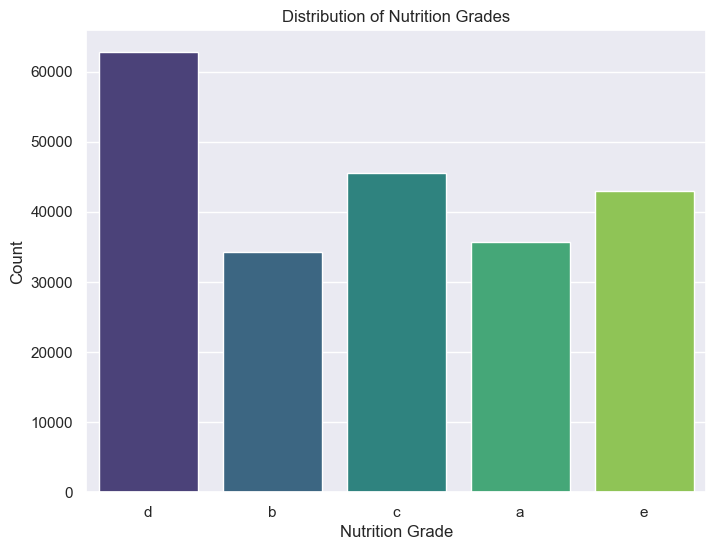

In [23]:
# Assuming 'products' is the DataFrame containing the modified column 'nutrition_grade_fr_n'  
sns.set(style="darkgrid")  
plt.figure(figsize=(8, 6))  
sns.countplot(data=products, x='nutrition_grade_fr', palette="viridis")  
plt.xlabel('Nutrition Grade')  
plt.ylabel('Count')  
plt.title('Distribution of Nutrition Grades')  
plt.show()  

In [46]:
test_data = products.copy()
test_data['nutrition_grade_fr'].value_counts()
test_data['nutrition_grade_fr_n'] = test_data['nutrition_grade_fr'].replace({'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5})

test_data.dropna(subset=["nutrition_grade_fr_n"], inplace=True)  
test_data["nutrition_grade_fr_n"].isna().mean() * 100

0.0

In [61]:
test_data.dropna(subset=["energy_100g"], inplace=True)  
test_data[["energy_100g", "nutrition-score-fr_100g"]].isna().mean() * 100

energy_100g                0.0
nutrition-score-fr_100g    0.0
dtype: float64

In [62]:
test_data_not_null = test_data[test_data["energy_100g"].notna() & test_data["nutrition_grade_fr_n"].notna() ] 
len(test_data_not_null)

221019

In [63]:
nan_count = test_data_not_null.isna().sum()  
print(nan_count)  

code                            0
url                             0
creator                         0
created_t                       0
created_datetime                1
                            ...  
nutrition-score-fr_100g         0
nutrition-score-uk_100g         0
glycemic-index_100g        221019
water-hardness_100g        221019
nutrition_grade_fr_n            0
Length: 163, dtype: int64


In [94]:

test_data_sampled = test_data_not_null.sample(frac=0.02, random_state=42)  

# Setting the label and the feature columns
y = test_data_sampled.loc[:,'nutrition_grade_fr_n'].values
x = test_data_sampled[['energy_100g',"nutrition-score-fr_100g"]].values


In [95]:
def plot_2d(component1, component2):
    
    fig = go.Figure(data=go.Scatter(
        x = component1,
        y = component2,
        mode='markers',
        marker=dict(
            size=20,
            color=y, #set color equal to a variable
            colorscale='Rainbow', # one of plotly colorscales
            showscale=True,
            line_width=1
        )
    ))
    fig.update_layout(margin=dict( l=100,r=100,b=100,t=100),width=1200,height=700)                 
    fig.layout.template = 'plotly_dark'
    
    fig.show()

In [96]:
def plot_3d(component1,component2,component3):
    fig = go.Figure(data=[go.Scatter3d(
        x=component1,
        y=component2,
        z=component3,
        mode='markers',
        marker=dict(
            size=10,
            color=y,                # set color to an array/list of desired values
            colorscale='Rainbow',   # choose a colorscale
            opacity=1,
            line_width=1
        )
    )])
    # tight layout
    fig.update_layout(margin=dict(l=50,r=50,b=50,t=50),width=1200,height=700)
    fig.layout.template = 'plotly_dark'
    
    fig.show()

In [98]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time

## Standardizing the data
x = StandardScaler().fit_transform(x)

start = time.time()
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)
print('Duration: {} seconds'.format(time.time() - start))
principal = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

Duration: 0.0010628700256347656 seconds


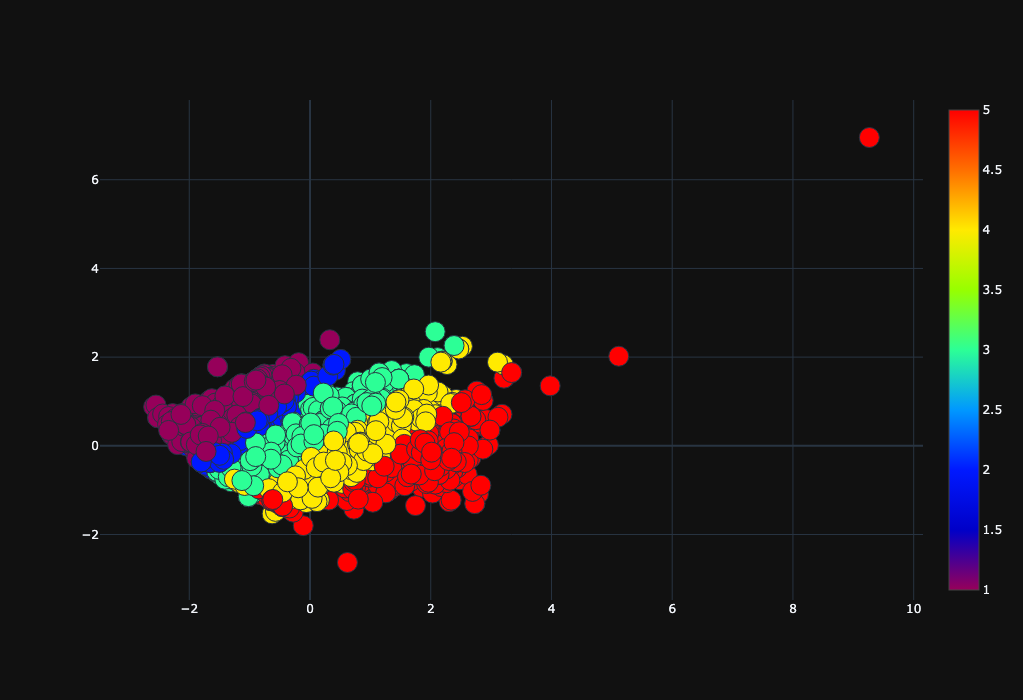

In [99]:
plot_2d(principalComponents[:, 0],principalComponents[:, 1])

In [104]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import time

start = time.time()
X_LDA = LDA(n_components=2).fit_transform(x,y)
print('Duration: {} seconds'.format(time.time() - start))

Duration: 0.010873079299926758 seconds


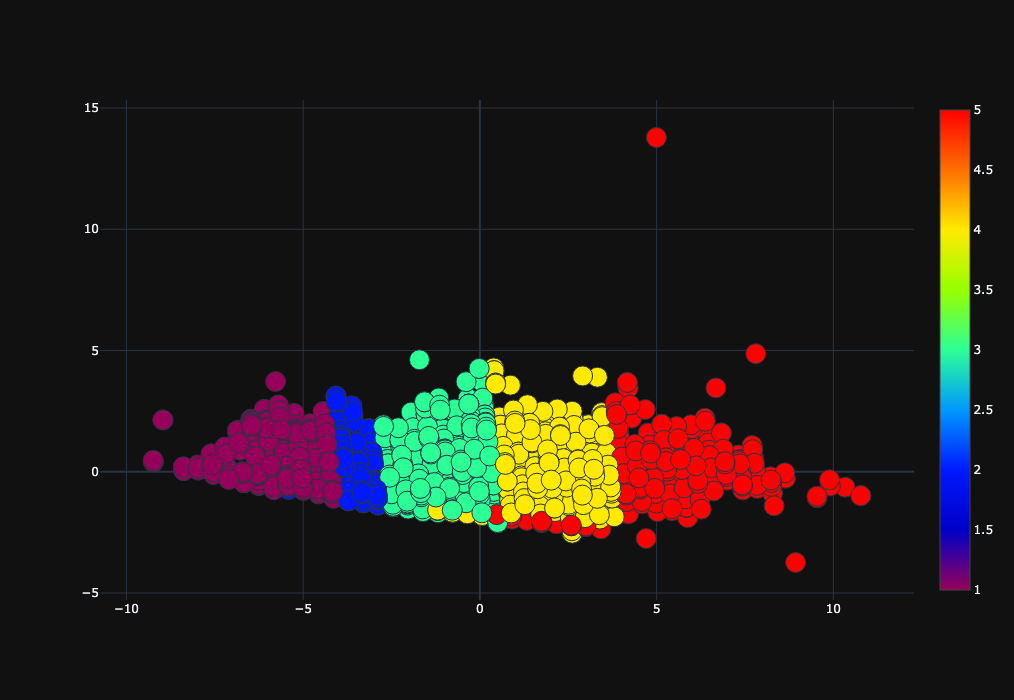

In [106]:
plot_2d(X_LDA[:, 0],X_LDA[:, 1])

But, comprendre si il y a une correlations entre les catégories et certaines colonnes de nutritions
- Je récupère uniquement les valeurs qui sont dans les top 10 des catégories
- Je récupère uniquement les valeurs qui ont un nutri score

- Je modifie le nutri score en nombres
- J'effectue une regression lineaire